# Определение стоимости автомобилей

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Описание данных**

Датафрейм **autos_csv**, имеющий следующие столбцы:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**План проекта**

1. [Загрузка данных](#section_1)
2. [Подготовка данных](#section_2)
3. [Корреляционныйы анализ](#section_3)
4. [Обучение моделей](#section_4)
5. [Анализ моделей](#section_5)
6. [Общий вывод](#section_6)

In [2]:
import warnings
import time
import pandas as pd
import seaborn as sns
import numpy as np
import lightgbm as lgb

from matplotlib import pyplot as plt

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

In [3]:
warnings.filterwarnings('ignore')

## Загрузка данных
<a id='section_1'></a>

In [4]:
autos = pd.read_csv('/datasets/autos.csv')

In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
autos.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer',
                 'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code',
                 'last_seen']

In [8]:
autos['date_crawled'] = pd.to_datetime(autos['date_crawled'])
autos['date_created'] = pd.to_datetime(autos['date_created'])
autos['last_seen'] = pd.to_datetime(autos['last_seen'])

### Вывод после загрузки данных

- Загрузили датафрейм autos из файла autos.csv [354369 строк и 16 столбцов].
- Описание данных в пункте "Описание данных" выше.
- Привели названия столбцов к snake_case.
- Есть пропуски в столбцах: vehicle_type, gearbox, model, fuel_type и repaired.
- Изменили типы данных в столбцах: date_crowled, date_created и last_seen к типу datetime.

## Подготовка данных
<a id='section_2'></a>

In [9]:
#Функция выводящая гистограмму и диаграмму размаха для колличественных признаков
def hist_box(df, col, bins):
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout(h_pad=1)
    fig.set_figheight(6)
    fig.set_figwidth(14)

    hist_graph = ax[0]
    boxplot_graph = ax[1]
    
    hist_graph.grid(True)
    boxplot_graph.grid(True)
    
    hist_graph.set_title(f'Гистограмма для {col}')
    boxplot_graph.set_title(f'Диаграмма размаха {col}')
    
    hist_graph.set_xlabel(col)
    hist_graph.set_ylabel('Колличество')
    
    boxplot_graph.set_xlabel(col)
    
    sns.histplot(df, ax=hist_graph, x=col, bins=bins)
    sns.boxplot(data=df, ax=boxplot_graph, x=col)

    plt.show()

### Анализ столбцов по отдельности

#### price

In [10]:
autos['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

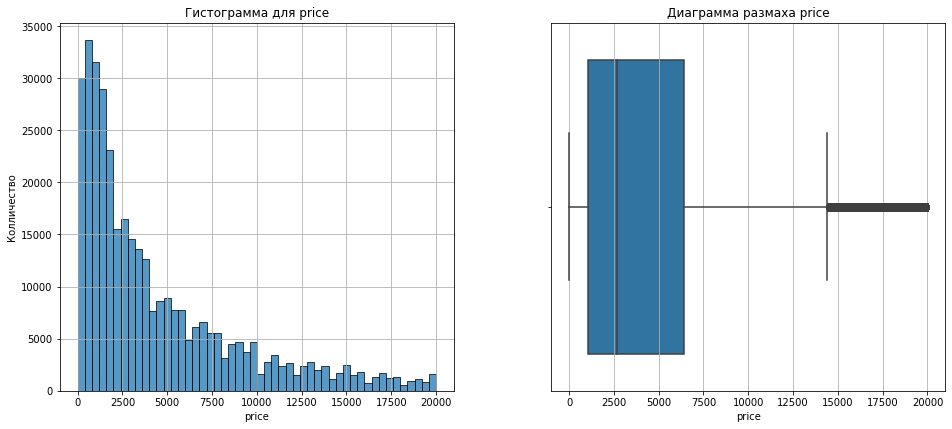

In [11]:
hist_box(autos, 'price', 50)

In [12]:
autos.query('price <= 100')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32
354309,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09,0,91301,2016-04-06 22:15:32


In [13]:
autos = autos.query('price > 100')

Удалили строки, где цена ниже или равна 100 евро, т.к. это слишком малая цена для реальности.

#### vehicle_type

In [14]:
autos['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [15]:
autos.loc[autos['vehicle_type'].isna(), 'vehicle_type'] = 'other'

Заменили пустые значения на 'other'

#### registration_year

In [16]:
autos['registration_year'].describe()

count    340024.000000
mean       2003.976778
std          69.885174
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

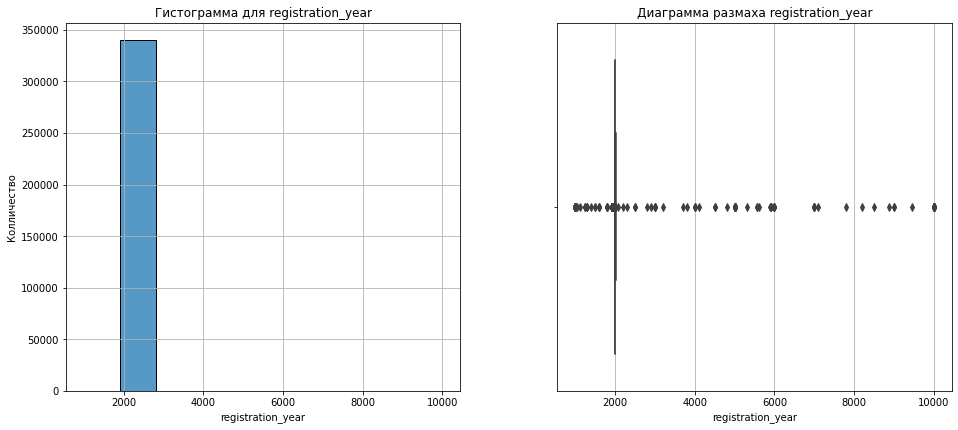

In [17]:
hist_box(autos, 'registration_year', 10)

In [18]:
print(sorted(autos['registration_year'].unique()))

[1000, 1001, 1039, 1111, 1234, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800, 8200, 8500, 8888, 9000, 9450, 9999]


In [19]:
autos = autos.query('1980 <= registration_year <= 2019')

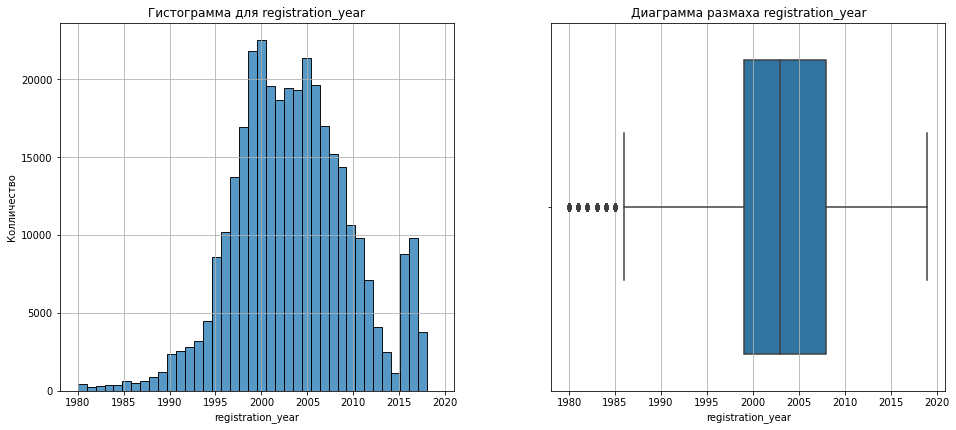

In [20]:
hist_box(autos, 'registration_year', 40)

Ограничили года регистрации автомобилей от 1980 до 2019 включительно, т.к. все остальные данные выглядят как выбросы, а стоимость автомобиля будет сильно зависеть от года регистрации.

#### gearbox

In [21]:
autos['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [22]:
autos.query('gearbox.isna()')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
16,2016-04-01 12:46:46,300,other,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,other,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,other,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16,0,51427,2016-03-21 09:47:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,other,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,other,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04


In [23]:
autos.dropna(subset=['gearbox'], inplace=True)

In [24]:
autos['gearbox'].value_counts()

manual    257376
auto       63998
Name: gearbox, dtype: int64

Избавились от пустых значений путем удаления всей строки, т.к. коробка передачь будет сильно влиять на стоимость, делать синтетическую категорию не целесообразно. 

#### power

In [25]:
autos['power'].describe()

count    321374.000000
mean        115.300236
std         187.051329
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

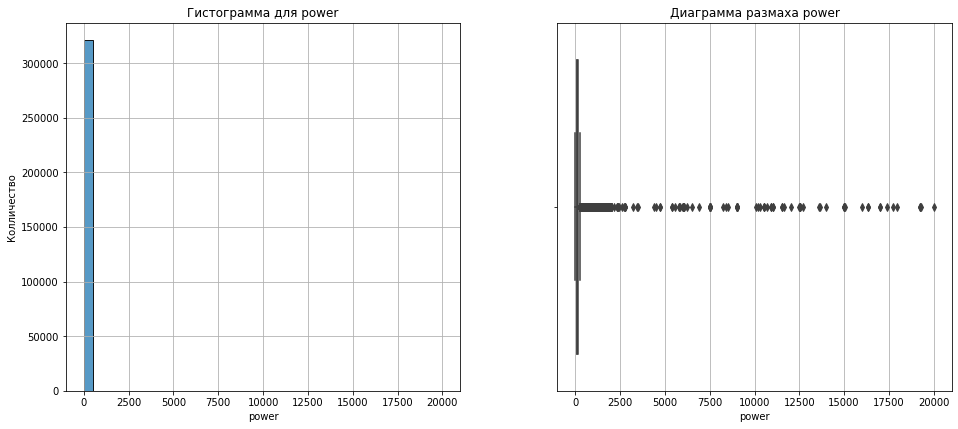

In [26]:
hist_box(autos, 'power', 40)

In [27]:
autos = autos.query('20 <= power <= 500')

In [28]:
autos.query('power > 400')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
2781,2016-03-16 00:37:16,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no,2016-03-16,0,38448,2016-04-01 22:47:31
3289,2016-03-10 17:46:47,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no,2016-03-10,0,44319,2016-04-03 18:47:41
4681,2016-03-25 17:57:37,13900,sedan,2006,auto,476,e_klasse,150000,5,petrol,mercedes_benz,no,2016-03-25,0,52078,2016-04-06 23:17:21
5319,2016-03-27 17:57:40,10999,wagon,2006,auto,435,other,150000,12,petrol,audi,yes,2016-03-27,0,52249,2016-04-01 19:17:31
10354,2016-03-27 20:47:03,18900,wagon,2007,auto,420,3er,150000,12,petrol,bmw,no,2016-03-27,0,92358,2016-04-05 19:18:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348785,2016-03-25 22:37:13,19780,wagon,2003,auto,500,e_klasse,150000,9,petrol,mercedes_benz,no,2016-03-25,0,32105,2016-03-26 00:51:17
351834,2016-03-11 14:36:18,10500,sedan,2003,auto,445,7er,150000,12,petrol,bmw,no,2016-03-11,0,86420,2016-04-05 11:48:37
352322,2016-03-29 18:06:23,15999,wagon,2007,auto,435,other,150000,2,petrol,audi,no,2016-03-29,0,65510,2016-04-06 05:46:42
354045,2016-03-22 20:48:48,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no,2016-03-22,0,38118,2016-03-24 05:16:02


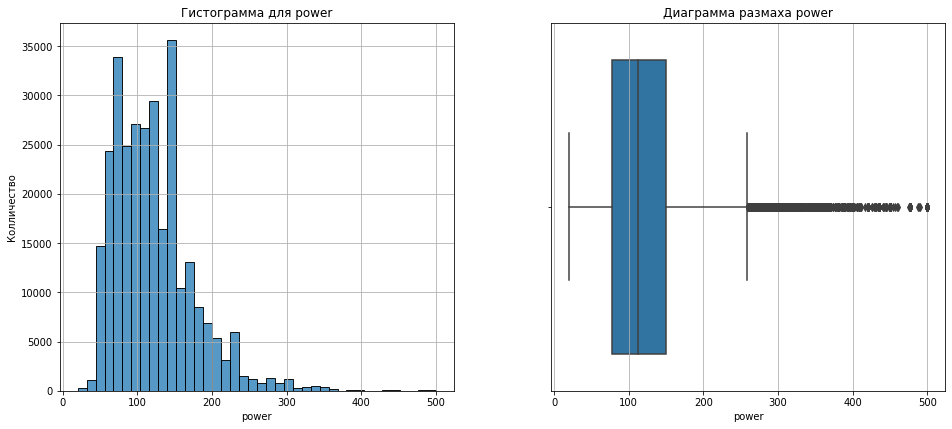

In [29]:
hist_box(autos, 'power', 40)

Ограничили мощность машин от 20 до 500 включительно, т. к. все остальные значения мощности выглядят не достоверно, а мощность сильно влияет на стоимость.

#### model

In [30]:
autos[autos['model'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
193,2016-03-27 12:47:45,1200,coupe,1990,manual,45,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27,0,83317,2016-04-07 08:17:08
273,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29,0,32791,2016-04-06 20:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354077,2016-03-21 08:36:18,200,small,1998,manual,37,NaN,150000,4,petrol,volkswagen,yes,2016-03-21,0,26382,2016-04-06 02:45:28
354234,2016-03-19 01:47:31,5000,sedan,2002,auto,170,NaN,150000,0,petrol,audi,no,2016-03-18,0,85221,2016-04-06 03:45:36
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07,0,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:25


In [31]:
autos.dropna(subset=['model'], inplace=True)

Модель сильно влияет на стоимость, поэтому заменить пропуски на синтетические мы не можем, поэтому избавляемся от этих строк.

#### kilometer

In [32]:
autos['kilometer'].describe()

count    285771.000000
mean     128638.000357
std       36302.535770
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

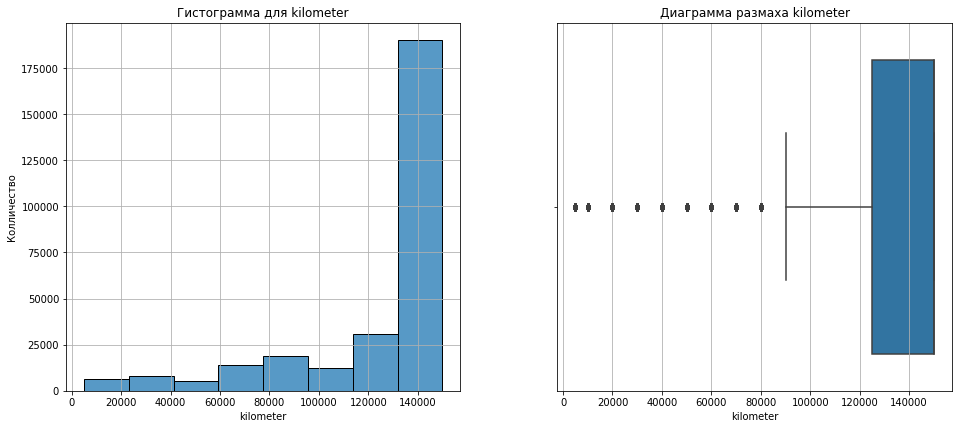

In [33]:
hist_box(autos, 'kilometer', 8)

С данными все хорошо, аномалий не обнаружено.

#### registration_month

In [34]:
sorted(autos['registration_month'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [35]:
autos['registration_month'].value_counts()

3     29673
6     26698
4     25000
5     24789
7     22947
10    22344
12    20684
11    20615
9     20461
1     19522
8     19203
2     18294
0     15541
Name: registration_month, dtype: int64

In [36]:
autos.loc[autos['registration_month'] == 0, 'registration_month'] = 6

У нас 13 уникальных значений месяца, следовательно от одного значения нам надо избавится, чтобы месяцев стало 12, заменим 0 на середину, т. е.: 6.

#### fuel_type

In [37]:
autos['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [38]:
autos['fuel_type'].fillna('other', inplace=True)

Заполнили пустые значения на other, т.к. тип топлива не будет сильно влиять на стоимость автомобиля.

#### brand

In [39]:
autos['brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

Здесь все в порядке, аномалий не обнаружено.

#### repaired

In [40]:
autos['repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [41]:
autos['repaired'].isna().sum()

39582

In [42]:
autos['repaired'].fillna('unknown', inplace=True)

Заменили пропуски в столбце repaired на unknown, т. к. сильно на стоимость этот столбец не влияет, а также не хочется терять почти 40 тыс. записей.

#### number_of_pictures

In [43]:
autos['number_of_pictures'].unique()

array([0])

In [44]:
autos.drop(['number_of_pictures'], axis =1, inplace=True)

Бесполезный столбцей, содержащий в себе исключительно нули, удалили из выборки.

#### postal_code

In [45]:
autos['postal_code'].describe()

count    285771.000000
mean      51266.704050
std       25747.931471
min        1067.000000
25%       30966.000000
50%       50321.000000
75%       72108.000000
max       99998.000000
Name: postal_code, dtype: float64

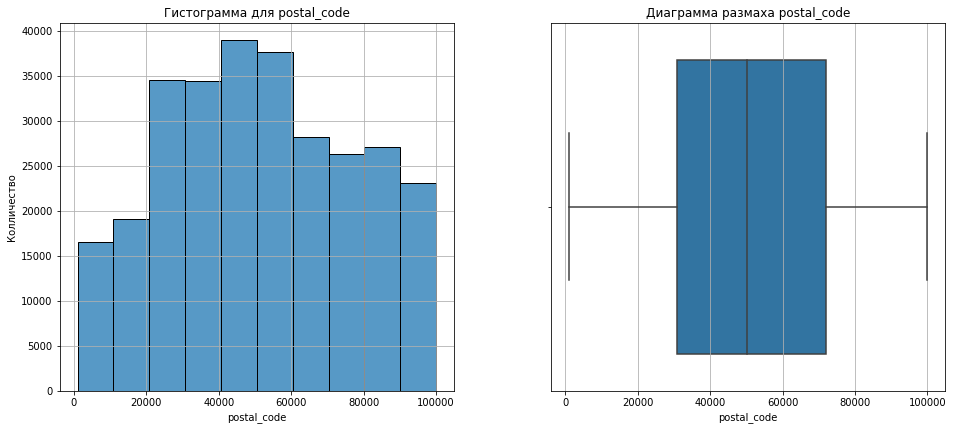

In [46]:
hist_box(autos, 'postal_code', 10)

In [47]:
first_nums = []
for num in np.array(autos['postal_code']):
    first_nums.append(int(str(num)[0]))
autos['geography_code'] = first_nums

In [48]:
autos.drop(['postal_code'], axis =1, inplace=True)

Сам по себе почтовый код нам не дает никакой иформации для модели, т.к. почти для каждой записи будет уникальным (будет очень много категориальных данных). Однако первое числе почтового индекса всегда отсылает к георгафической принадлежности, а вот она уже может влиять на стоимость автомобилей, поэтому заменили почтовый код в каждой записи на его первое число, т.е. географический код (geography_code).

#### Даты (date_crawled, date_created, last_seen)

In [49]:
autos[['date_crawled', 'date_created', 'last_seen']].describe()

,date_crawled,date_created,last_seen
count,285771,285771,285771
unique,230503,106,150151
top,2016-03-19 21:49:56,2016-04-03 00:00:00,2016-04-07 09:44:27
freq,6,11281,15
first,2016-03-05 14:06:22,2015-03-20 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


Данные о датах создания и скачивания анкет, а ткаже последней активности пользователя для модели не нужны.

### Анализ пропусков

In [50]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285771 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        285771 non-null  datetime64[ns]
 1   price               285771 non-null  int64         
 2   vehicle_type        285771 non-null  object        
 3   registration_year   285771 non-null  int64         
 4   gearbox             285771 non-null  object        
 5   power               285771 non-null  int64         
 6   model               285771 non-null  object        
 7   kilometer           285771 non-null  int64         
 8   registration_month  285771 non-null  int64         
 9   fuel_type           285771 non-null  object        
 10  brand               285771 non-null  object        
 11  repaired            285771 non-null  object        
 12  date_created        285771 non-null  datetime64[ns]
 13  last_seen           285771 no

Пропуски отсутствуют.

### Анализ дубликатов

In [51]:
autos.duplicated().sum()

4

In [52]:
autos[autos.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,last_seen,geography_code
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,2016-03-09 09:46:57,8
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,2016-03-28 08:46:21,6
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,2016-04-07 09:44:54,7
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,2016-03-18 18:46:15,3


In [53]:
autos = autos.drop_duplicates().reset_index(drop = True)

Избавились от 4 дубликатов.

### Просмотр готовых данных
<a id='section_3'></a>

#### Колличественные данные

In [54]:
quantitative_features = ['price', 'registration_year', 'power', 'kilometer', 'registration_month']
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [55]:
autos[['price', 'registration_year', 'power', 'kilometer', 'registration_month']].describe()

,price,registration_year,power,kilometer,registration_month
count,285767.000000,285767.000000,285767.000000,285767.000000,285767.000000
mean,4896.429262,2003.558903,120.885547,128638.243744,6.366382
std,4595.773106,6.223684,52.800875,36302.176378,3.259258
min,101.000000,1980.000000,20.000000,5000.000000,1.000000
25%,1400.000000,1999.000000,80.000000,125000.000000,4.000000
50%,3200.000000,2003.000000,113.000000,150000.000000,6.000000
75%,6999.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,2019.000000,500.000000,150000.000000,12.000000


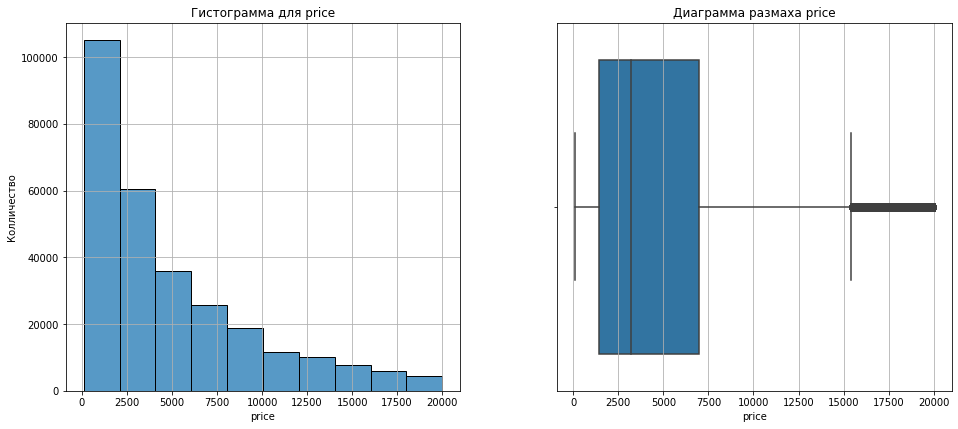

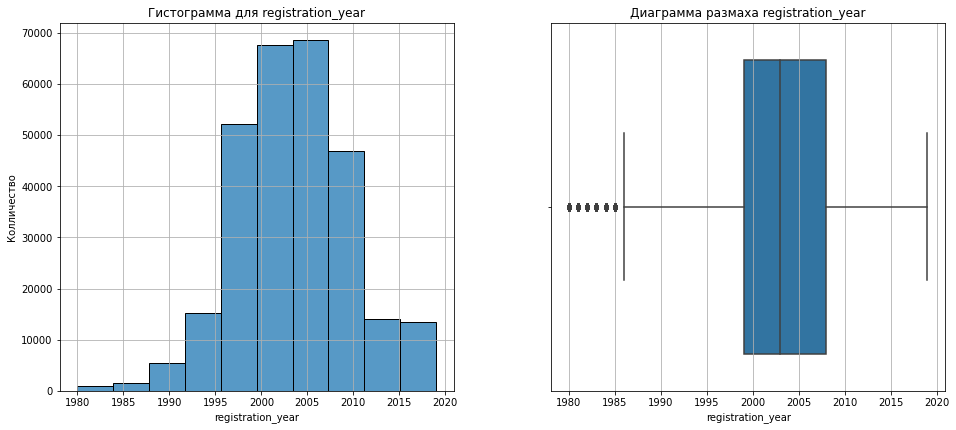

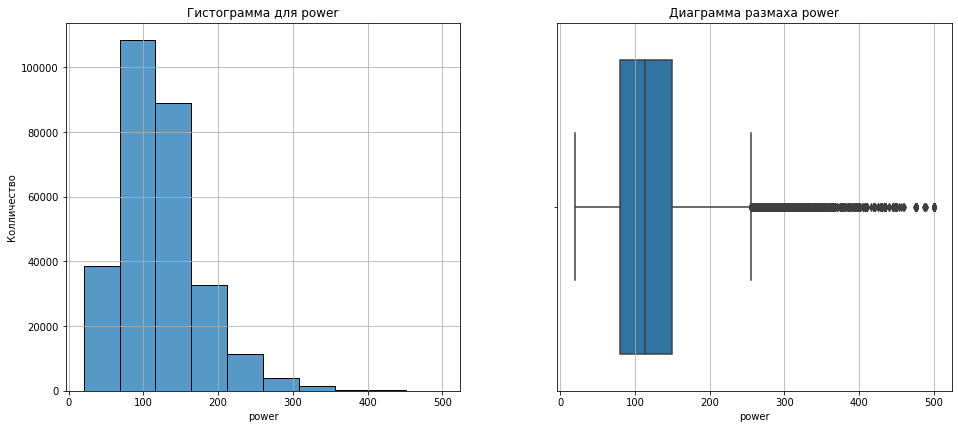

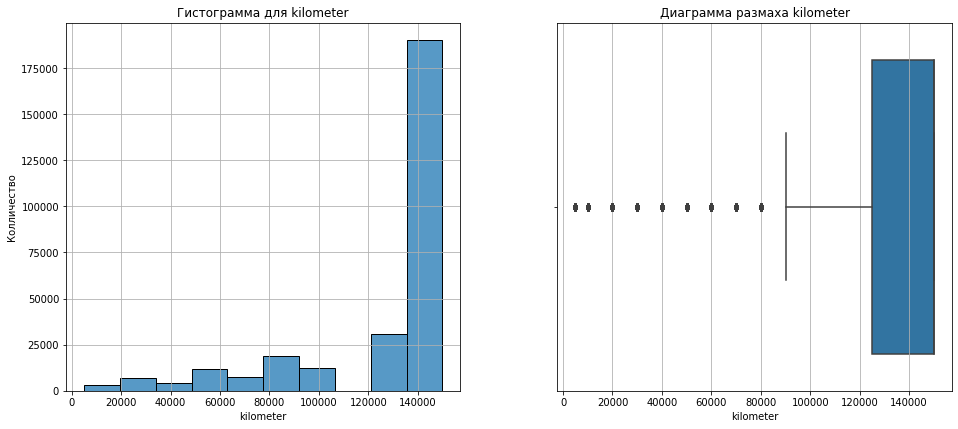

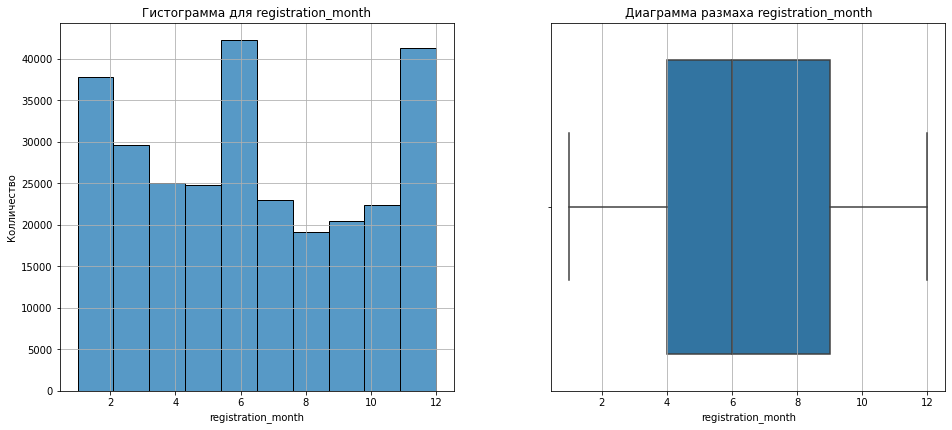

In [56]:
for col in quantitative_features:
    hist_box(autos, col, 10)

#### Категориальные признаки

In [57]:
#Функция для постороения столбчатой и круговой диаграмм для категориальных данных
def bar_pie(df, col, values):
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout(h_pad=1)
    fig.set_figheight(4)
    fig.set_figwidth(14)
    
    piv = pd.pivot_table(df, index=col, values=values, aggfunc='count')
    
    bar = ax[0]
    pie = ax[1]
    
    sns.countplot(data=df, y=col, ax=bar)
    piv.plot(y=values, kind='pie', ax=pie, autopct='%1.1f%%', colors=sns.color_palette('muted') )
    
    pie.yaxis.set_visible(False)
    pie.get_legend().remove()
    
    bar.tick_params(labelrotation=0)
    bar.set_xlabel('Кол-во машин')
    bar.yaxis.set_visible(True)
    bar.set_title(f'Столбчатая диаграмма для столбца: {col}')
    bar.grid(True)
    
    pie.set_title(f'Круговая диаграмма для столбца: {col}')

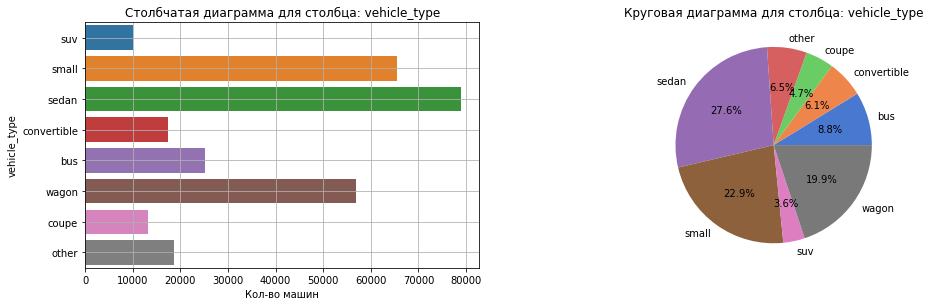

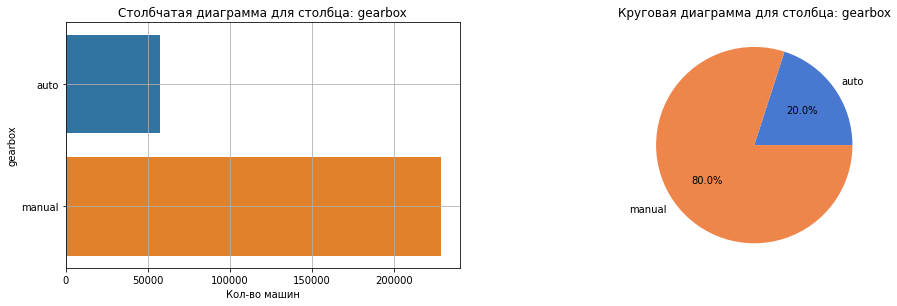

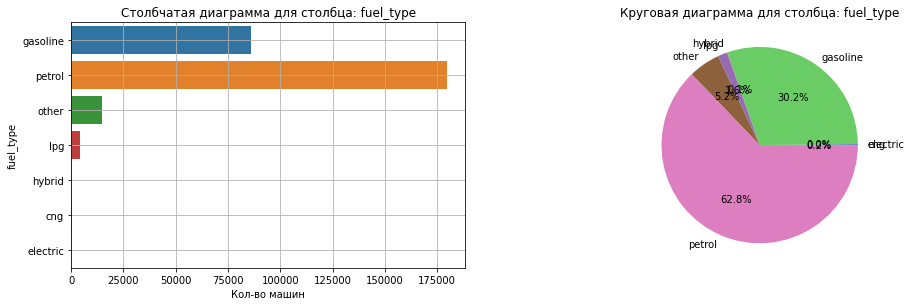

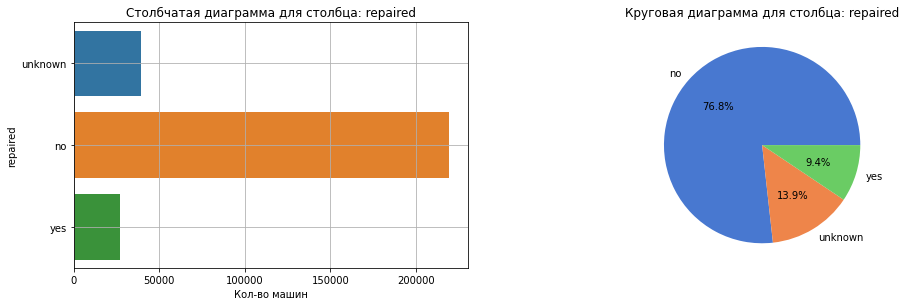

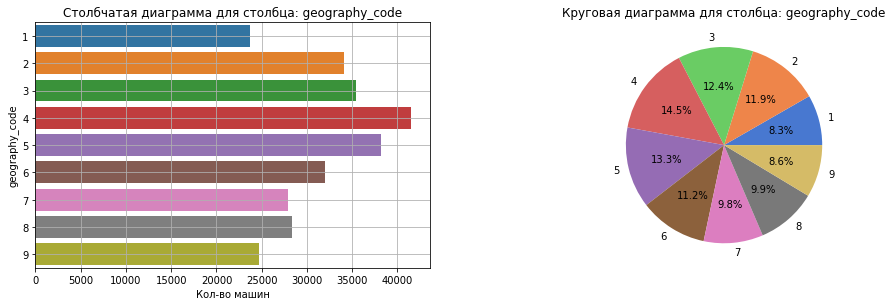

In [58]:
cols = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'geography_code']
for col in cols:
    bar_pie(autos, col, 'price')

In [59]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285767 entries, 0 to 285766
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        285767 non-null  datetime64[ns]
 1   price               285767 non-null  int64         
 2   vehicle_type        285767 non-null  object        
 3   registration_year   285767 non-null  int64         
 4   gearbox             285767 non-null  object        
 5   power               285767 non-null  int64         
 6   model               285767 non-null  object        
 7   kilometer           285767 non-null  int64         
 8   registration_month  285767 non-null  int64         
 9   fuel_type           285767 non-null  object        
 10  brand               285767 non-null  object        
 11  repaired            285767 non-null  object        
 12  date_created        285767 non-null  datetime64[ns]
 13  last_seen           285767 no

### Вывод после подготовки данных

С данными было сделано следующее:

- price: Удалили строки, где цена ниже или равна 100 евро, т.к. это слишком малая цена для реальности.
- vehicle_type: Заменили пустые значения на 'other'.
- registration_year: Ограничили года регистрации автомобилей от 1980 до 2019 включительно, т.к. все остальные данные выглядят как выбросы, а стоимость автомобиля будет сильно зависеть от года регистрации.
- gearbox: Избавились от пустых значений путем удаления всей строки, т.к. коробка передачь будет сильно влиять на стоимость, делать дополнитетельную категорию не целесообразно.
- power: Ограничили мощность машин от 20 до 500 включительно, т. к. все остальные значения мощности выглядят не достоверно, а мощность сильно влияет на стоимость.
- model: Модель сильно влияет на стоимость, поэтому заменить пропуски на синтетические мы не можем.
- kilometer С данными все хорошо, аномалий не обнаружено.
- registration_month: У нас 13 уникальных значений месяца, следовательно от одного значения нам надо избавится, чтобы месяцев стало 12, заменим 0 на середину, т. е.: 6.
- fuel_type: Заполнили пустые значения на other, т.к. тип топлива не будет сильно влиять на стоимость автомобиля.
- brand: Здесь все в порядке, аномалий не обнаружено.
- repaired: Заменили пропуски в столбце repaired на unknown, т. к. сильно на стоимость этот столбец не влияет, а также не хочется терять почти 40 тыс. записей.
- number_of_pictures: Бесполезный столбцей, содержащий в себе исключительно нули, удалили из выборки.
- postal_code: Сам по себе почтовый код нам не дает никакой иформации для модели, т.к. почти для каждой записи будет уникальным (будет очень много категориальных данных). Однако первое числе почтового индекса всегда отсылает к георгафической принадлежности, а вот она уже может влиять на стоимость автомобилей, поэтому заменили почтовый код в каждой записи на его первое число, т.е. географический код (geography_code).
- Даты (date_crawled, date_created, last_seen): Данные о датах создания и скачивания анкет, а ткаже последней активности пользователя для модели не нужны.

По итогу было удалено примерно 70 тыс строк, осталось примерно 285767 строк.

## Корреляционный анализ
<a id='section_3'></a>

In [60]:
autos_model = autos[['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer',
                 'registration_month', 'fuel_type', 'brand', 'repaired', 'geography_code']].copy()

In [61]:
autos_model.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,geography_code
0,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,9
1,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9
2,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6
3,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,3
4,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,6


In [62]:
# Расчет матрицы корреляции
interval_cols = ['price', 'power', 'kilometer']
phik_overview = autos_model.phik_matrix(interval_cols=interval_cols)

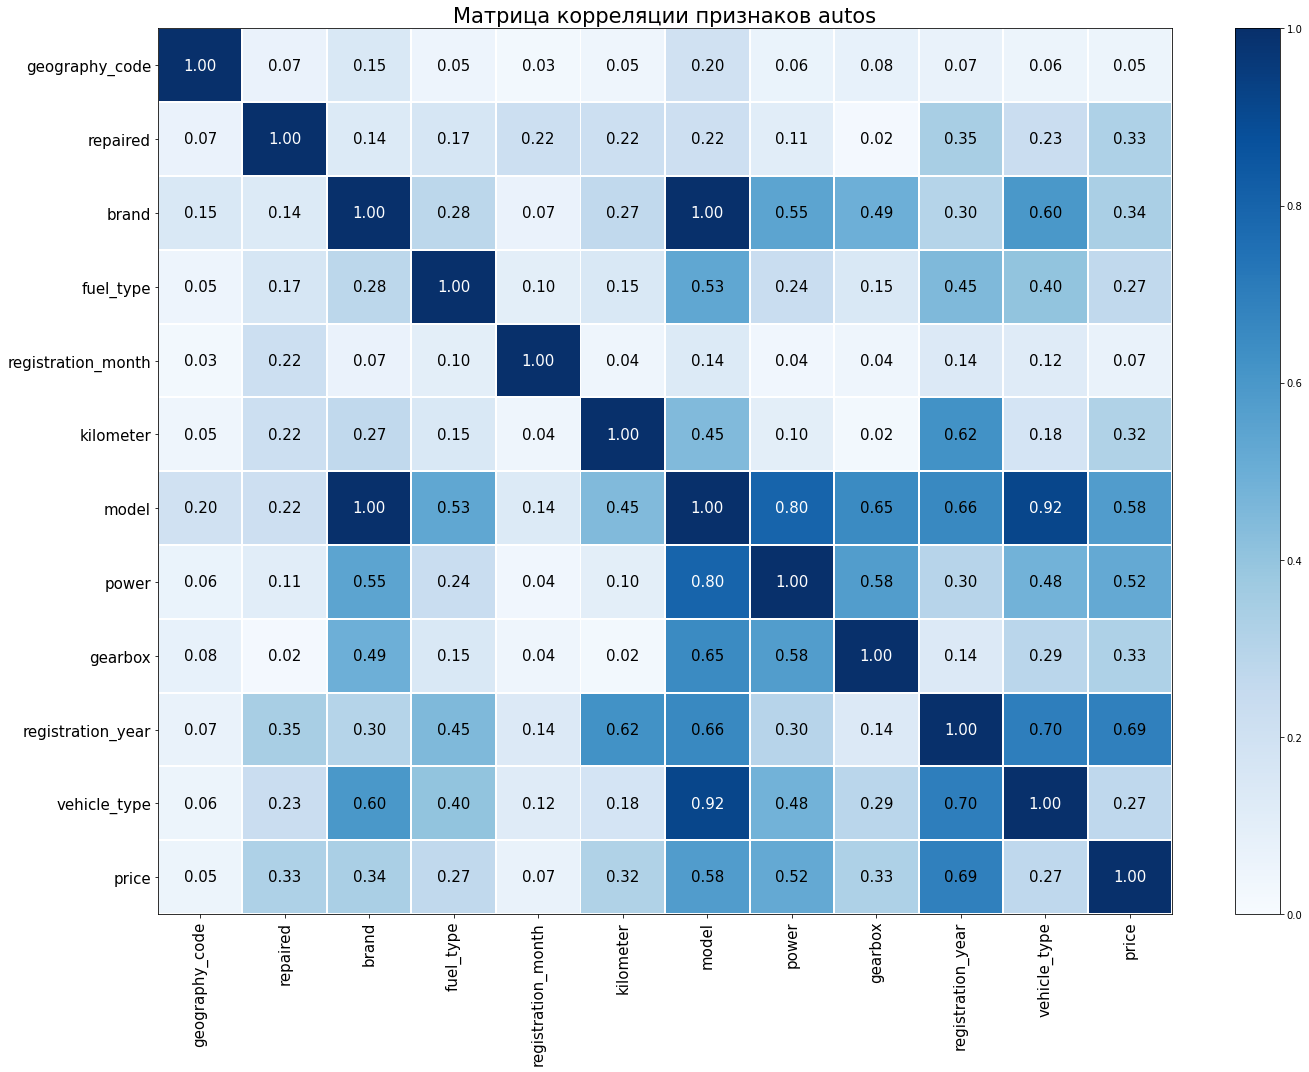

In [63]:
# Построение матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title='Мaтрица корреляции признаков autos',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Вывод после корреляционного анализа

Самая высокая корреляция у целевого признака price с registration_year (0.69), model (0.58) и power (0.52). Наблюдается высокая корреляция входных признаков между vehicle_type и model (0.92), и brand и model (1.0), во втором случае наблюдается мультиколлинеарность, однако если убрать model из входных данных, то точность всех моделей незначительно, но упадет, поэтому было принято решение model оставить.

## Обучение моделей
<a id='section_4'></a>

### Подготовка выборок и кодирование данных

Категориальные данные мы будем готовть 2мя способами OneHotEncoder и OrdinalEncoder, чтобы посмотреть с каким способом будут более эффективные модели. Минус ohe в том, что при большом кол-ве категорий становится очень много столбцов, у нас именно такая ситуация со столбцах model и brand. Минус OrdinalEncoder, в нашем случае в том, что у нас нет порядковых категориальных данных, т.е мы просто в рандомном порядке можем преобразовать категориальные данные в числа. 

Для модели CatBoost категориальные данные предобрабатываться не будут, потому что CatBoost делает это сам.

Мы будем тестировать 3 модели: LinearRegression, CatBoostRegressor и LGBMRegressor. Для 1ой и 3ей модели мы будем использовать по 2 типа предподготовленных данных с помощью ohe и ord, т.е в итоге получится 5 моделей.

Мы будем замерять скорость обучения моделей (fit_time), скорость предсказания (predict_time) и RMSE моделей, заносить все эти данные в датафрейм (models_results) и в дальнейшем сравнивать по этим данным все эти модели.

#### Подготовка данных с использованием OneHotEncoder

In [64]:
def train_val_test(df, target):
    X = df.drop(target, axis=1)
    y = df[target]

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, 
        y, 
        random_state=1, test_size = 0.2)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, 
        y_train_val, 
        random_state=1, test_size = int(0.2 * len(X)))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [65]:
#Функция для подготовки данных к обучению и тестированию модели 
def preparing_data_for_training_ohe(df, target):
    #Разделение данныз на выборки
    RANDOM_STATE = 1

    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(df, target)
    
    quantitive_features = X_train.select_dtypes(exclude='object').columns.to_list()
    categorical_features = X_train.select_dtypes(include='object').columns.to_list()

    #Масштабирование колличетсвенных признаков
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train[quantitive_features])
    X_val_scaled = scaler.transform(X_val[quantitive_features])
    X_test_scaled = scaler.transform(X_test[quantitive_features])
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=quantitive_features)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=quantitive_features)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=quantitive_features)

    #Использование OneHotEncoder для категориальных признаков (кодирование признаков) 
    encoder = OneHotEncoder(drop='first', sparse=False)
    
    X_train_ohe = encoder.fit_transform(X_train[categorical_features])
    X_val_ohe = encoder.transform(X_val[categorical_features])
    X_test_ohe = encoder.transform(X_test[categorical_features])

    encoder_col_names = encoder.get_feature_names()
    
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_val_ohe = pd.DataFrame(X_val_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    #Соедиение в один датафрейм
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_val = pd.concat([X_val_ohe, X_val_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [66]:
%%time

X_train_ohe, X_val_ohe, X_test_ohe, y_train_ohe, y_val_ohe, y_test_ohe = preparing_data_for_training_ohe(autos_model, 'price')

CPU times: user 2.88 s, sys: 1 s, total: 3.88 s
Wall time: 3.88 s


#### Подготовка данных с использованием OrdinalEncoder

In [67]:
def preparing_data_for_training_ord(df, target):
    
    RANDOM_STATE = 1
    categorical_features = df.select_dtypes(include='object').columns.to_list()
    
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(df, target)
    
    encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = np.nan)
    encoder.fit(X_train[categorical_features])
    
    X_train[categorical_features] = encoder.transform(X_train[categorical_features])
    X_val[categorical_features] = encoder.transform(X_val[categorical_features])
    X_test[categorical_features] = encoder.transform(X_test[categorical_features])
    
    scale_cols = X_train.columns
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[scale_cols] = scaler.transform(X_train[scale_cols])
    X_val[scale_cols] = scaler.transform(X_val[scale_cols])
    X_test[scale_cols] = scaler.transform(X_test[scale_cols])
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [68]:
%%time

X_train_ord, X_val_ord, X_test_ord, y_train_ord, y_val_ord, y_test_ord = preparing_data_for_training_ord(autos_model, 'price')

CPU times: user 1.41 s, sys: 103 ms, total: 1.51 s
Wall time: 1.51 s


#### Подготовка датафрейма для результатов

In [69]:
models_results = pd.DataFrame(columns=['model', 'preprocessing_method', 'fit_time_sec', 'predict_time_sec', 'rmse'])
models_results['fit_time_sec'] = models_results['fit_time_sec'].astype('int')
models_results['predict_time_sec'] = models_results['predict_time_sec'].astype('int')
models_results['rmse'] = models_results['rmse'].astype('int')

In [70]:
def create_model(model, X_train, y_train):
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    return model, round(end - start, 3)

In [71]:
def model_predict(model, X_val, y_val):
    start = time.time()
    preds = model.predict(X_val)
    end = time.time()
    return round(mean_squared_error(y_val, preds)**0.5, 2), round(end - start, 3)

In [72]:
def add_to_models_results(df, model_name, preproc_method, fit_time, predict_time, rmse):
    
    names_dict = {'models_names': {'lr': 'LinearRegressor',
                                   'cb': 'CatBoostRegressor',
                                   'lgbm': 'LightGBMRegressor'},
                  'preproc_names': {'ohe': 'OneHotEncoder',
                                    'ord': 'OrdinalEncoder',
                                    'cb': 'CatBoost'}
             }
    
    return  df.append({'model': names_dict['models_names'][model_name],
                       'preprocessing_method': names_dict['preproc_names'][preproc_method],
                       'fit_time_sec': fit_time,
                       'predict_time_sec': predict_time,
                       'rmse': rmse},
                        ignore_index=True)

#### OneHotEncoder

In [73]:
%%time
linear_model_ohe, linear_ohe_fit_time = create_model(LinearRegression(), X_train_ohe, y_train_ohe)

CPU times: user 12.4 s, sys: 5.66 s, total: 18.1 s
Wall time: 18.1 s


In [74]:
linear_rmse_ohe, linear_ohe_predict_time = model_predict(linear_model_ohe, X_val_ohe, y_val_ohe)
print('Linear Regression RMSE with OHE:', linear_rmse_ohe)

Linear Regression RMSE with OHE: 2399.9


In [75]:
models_results = add_to_models_results(models_results, 'lr', 'ohe', linear_ohe_fit_time,
                                       linear_ohe_predict_time, linear_rmse_ohe)

#### OrdinalEncoder

In [76]:
%%time
linear_model_ord, linear_ord_fit_time = create_model(LinearRegression(), X_train_ord, y_train_ord)

CPU times: user 60.2 ms, sys: 12.9 ms, total: 73.1 ms
Wall time: 45.8 ms


In [77]:
linear_rmse_ord, linear_ord_predict_time = model_predict(linear_model_ord, X_val_ord, y_val_ord)
print('Linear Regression RMSE with OrdinalEncoder:', linear_rmse_ord)

Linear Regression RMSE with OrdinalEncoder: 2829.49


In [78]:
models_results = add_to_models_results(models_results, 'lr', 'ord', linear_ord_fit_time,
                                       linear_ord_predict_time, linear_rmse_ord)

### CatBoost

In [79]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(autos_model, 'price')

In [80]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
cat_boost_model = CatBoostRegressor(iterations = 100)

In [81]:
%%time
start = time.time()
cat_boost_model.fit(X_train, y_train, cat_features=cat_features, verbose=20)
end = time.time()
cat_boost_fit_time = round(end - start, 3)

Learning rate set to 0.5
0:	learn: 3269.5560957	total: 131ms	remaining: 13s
20:	learn: 1769.2021784	total: 1.4s	remaining: 5.28s
40:	learn: 1675.7887942	total: 2.62s	remaining: 3.76s
60:	learn: 1634.5442886	total: 3.83s	remaining: 2.45s
80:	learn: 1602.6730955	total: 5.06s	remaining: 1.19s
99:	learn: 1580.1894123	total: 6.21s	remaining: 0us
CPU times: user 6.46 s, sys: 48.4 ms, total: 6.51 s
Wall time: 7.32 s


In [82]:
cat_boost_rmse, cat_boost_predict_time = model_predict(cat_boost_model, X_val, y_val)
print('Cat Boost RMSE:', cat_boost_rmse)

Cat Boost RMSE: 1627.49


In [83]:
models_results = add_to_models_results(models_results, 'cb', 'cb', cat_boost_fit_time,
                                       cat_boost_predict_time, cat_boost_rmse)

### LightGBM

#### OneHotEncoder

In [84]:
%%time
lgbm_model_ohe, lgbm_ohe_fit_time = create_model(lgb.LGBMRegressor(num_leaves=50, max_depth=-1, learning_rate=0.1),
                                      X_train_ohe, y_train_ohe)

CPU times: user 10min 54s, sys: 5.32 s, total: 10min 59s
Wall time: 11min 4s


In [85]:
lgbm_rmse_ohe, lgbm_ohe_predict_time = model_predict(lgbm_model_ohe, X_val_ohe, y_val_ohe)
print('LightGBM RMSE with OHE:', lgbm_rmse_ohe)

LightGBM RMSE with OHE: 1592.06


In [86]:
models_results = add_to_models_results(models_results, 'lgbm', 'ohe', lgbm_ohe_fit_time,
                                       lgbm_ohe_predict_time, lgbm_rmse_ohe)

#### OrdinalEncoder

In [87]:
%%time
lgbm_model_ord, lgbm_ord_fit_time = create_model(lgb.LGBMRegressor(num_leaves=50, max_depth=-1, learning_rate=0.1),
                                                   X_train_ord, y_train_ord)

CPU times: user 7min 42s, sys: 4.68 s, total: 7min 46s
Wall time: 7min 49s


In [88]:
lgbm_rmse_ord, lgbm_ord_predict_time = model_predict(lgbm_model_ord, X_val_ord, y_val_ord)
print('LightGBM RMSE with OrdinalEncoder:', lgbm_rmse_ord)

LightGBM RMSE with OrdinalEncoder: 1615.26


In [89]:
models_results = add_to_models_results(models_results, 'lgbm', 'ord', lgbm_ord_fit_time,
                                       lgbm_ord_predict_time, lgbm_rmse_ord)

### Вывод после обучения моделей

Предобработали категориальные данные двумя способами: с помощью OneHotEncoder и OrdinalEncoder. 

Обучили всего 5 моделей:
- LinearRegressor: 2 модели с по разному предобработанными данными (ohe и ord).
- CatBoostRegressor: 1 модель, данные никак не предобрабатывались CatBoost это делает сам.
- LGBMRegressor: 2 модели с по разному предобработанными данными (ohe и ord).

Записали метрики (скорость обучения, скорость предсказания и rmse) моделей в датафрейм models_results.

## Анализ моделей
<a id='section_5'></a>

In [90]:
models_results.sort_values('rmse')

,model,preprocessing_method,fit_time_sec,predict_time_sec,rmse
3,LightGBMRegressor,OneHotEncoder,664.101,0.818,1592.06
4,LightGBMRegressor,OrdinalEncoder,469.593,0.597,1615.26
2,CatBoostRegressor,CatBoost,7.317,0.078,1627.49
0,LinearRegressor,OneHotEncoder,18.085,0.227,2399.90
1,LinearRegressor,OrdinalEncoder,0.046,0.064,2829.49


Все модели кроме линейной с ord удовлетворяют условию: rmse < 2500, следовательно задача выполнена.

Предобработка признаков с помощью ohe показала себя лучше с точки зрения RMSE на обеих моделях (линейной и древовидной), однако на линейной модели резко возрастает время обучения модели при использовании ohe, при этом если на линейной модели использовать ord, то очень сильно падает точность. С моделью lgbm картина немного другая: ohe по прежнему превосходит ord по RMSE, но совсем немного, при этом скорость обучения с ord для lgbm значительно выше, так что можно сказать, что ord как минимум не хуже для lgbm, чем ohe, а может и немного лучше по совокупности факторов.

Разница обычной линейной регрессией с lgbm и catboost, т.е. древовидными модели с градиентным бустингом, очень существенна в первую очередь по их точности. Между собой lgbm и catboost по точности почти не отличаются (немного изменить гиперпараметры и catboost спокойно может выйти на первое место по rmse...). Куда более важным фактором является то, что catboost сам предобрабатывает все признаки внутри себя, т.е. нам не надо тратить время на предобработку данных в отличии от остальных моделей, получается что catboost почти такой же по скорости обучения, что и lgbm с ord, также время предсказания гораздо выше, чем у lgbm. Если учитывать все факторы, то наиболее сбалансированной моделью для данной задачи является catboost.

Дополнительно изучим важность признаков для CatBoost и LGBM.

### LGBMRegressor важность признаков

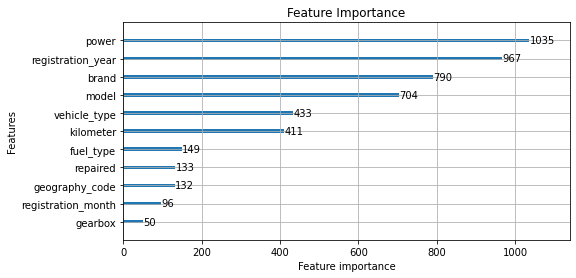

In [91]:
lgb.plot_importance(lgbm_model_ord, figsize=(8, 4))
plt.title("Feature Importance")
plt.show()

### CatBoostRegressor важность признаков

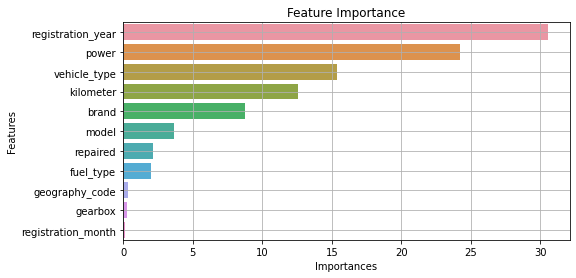

In [92]:
cat_boost_feature_importance = cat_boost_model.get_feature_importance(prettified=True)
cat_boost_feature_importance.columns = ['Features', 'Importances']
plt.figure(figsize=(8, 4))
sns.barplot(cat_boost_feature_importance['Importances'], cat_boost_feature_importance['Features'])
plt.title('Feature Importance')
plt.grid(True)
plt.show()

1. Рейтинг (топ-6) важности признаков для LGBM: registration_year, power, brand, kilometer, vehicle_type, model.
2. Рейтинг (топ-6) важности признаков для CatBoost: registration_year, power, vehicle_type, kilometer, brand, model.

**Как можно увидеть LGBM и CatBoost отдают примерно одинаковые приоритеты входным признакам с незначительными отличиями.**

### Лучшая модель на тестовой выборке

In [93]:
print('Cat Boost RMSE на тестовой выборке:', round(mean_squared_error(y_test, cat_boost_model.predict(X_test))**0.5, 2))

Cat Boost RMSE на тестовой выборке: 1597.27


## Общий вывод
<a id='section_6'></a>

**Загрузка данных**

- Загрузили датафрейм autos из файла autos.csv [354369 строк и 16 столбцов].
- Описание данных в пункте "Описание данных" выше.
- Привели названия столбцов к snake_case.
- Есть пропуски в столбцах: vehicle_type, gearbox, model, fuel_type и repaired.
- Изменили типы данных в столбцах: date_crowled, date_created и last_seen к типу datetime.

**Подготовка данных**

С данными было сделано следующее:

- price: Удалили строки, где цена ниже или равна 100 евро, т.к. это слишком малая цена для реальности.
- vehicle_type: Заменили пустые значения на 'other'.
- registration_year: Ограничили года регистрации автомобилей от 1980 до 2019 включительно, т.к. все остальные данные выглядят как выбросы, а стоимость автомобиля будет сильно зависеть от года регистрации.
- gearbox: Избавились от пустых значений путем удаления всей строки, т.к. коробка передачь будет сильно влиять на стоимость, делать дополнитетельную категорию не целесообразно.
- power: Ограничили мощность машин от 20 до 500 включительно, т. к. все остальные значения мощности выглядят не достоверно, а мощность сильно влияет на стоимость.
- model: Модель сильно влияет на стоимость, поэтому заменить пропуски на синтетические мы не можем.
- kilometer С данными все хорошо, аномалий не обнаружено.
- registration_month: У нас 13 уникальных значений месяца, следовательно от одного значения нам надо избавится, чтобы месяцев стало 12, заменим 0 на середину, т. е.: 6.
- fuel_type: Заполнили пустые значения на other, т.к. тип топлива не будет сильно влиять на стоимость автомобиля.
- brand: Здесь все в порядке, аномалий не обнаружено.
- repaired: Заменили пропуски в столбце repaired на unknown, т. к. сильно на стоимость этот столбец не влияет, а также не хочется терять почти 40 тыс. записей.
- number_of_pictures: Бесполезный столбцей, содержащий в себе исключительно нули, удалили из выборки.
- postal_code: Сам по себе почтовый код нам не дает никакой иформации для модели, т.к. почти для каждой записи будет уникальным (будет очень много категориальных данных). Однако первое числе почтового индекса всегда отсылает к георгафической принадлежности, а вот она уже может влиять на стоимость автомобилей, поэтому заменили почтовый код в каждой записи на его первое число, т.е. географический код (geography_code).
- Даты (date_crawled, date_created, last_seen): Данные о датах создания и скачивания анкет, а ткаже последней активности пользователя для модели не нужны.

По итогу было удалено примерно 70 тыс строк, осталось примерно 285767 строк.

**Корреляционный анализ**

Самая высокая корреляция у целевого признака price с registration_year (0.69), model (0.58) и power (0.52). Наблюдается высокая корреляция входных признаков между vehicle_type и model (0.92), и brand и model (1.0), во втором случае наблюдается мультиколлинеарность, однако если убрать model из входных данных, то точность всех моделей незначительно, но упадет, поэтому было принято решение model оставить.

**Обучение моделей**

Предобработали категориальные данные двумя способами: с помощью OneHotEncoder и OrdinalEncoder. 

Обучили всего 5 моделей:
- LinearRegressor: 2 модели с по разному предобработанными данными (ohe и ord).
- CatBoostRegressor: 1 модель, данные никак не предобрабатывались CatBoost это делает сам.
- LGBMRegressor: 2 модели с по разному предобработанными данными (ohe и ord).

Записали метрики (скорость обучения, скорость предсказания и rmse) моделей в датафрейм models_results.

**Анализ моделей (Итог)**

Все модели кроме линейной с ord удовлетворяют условию: rmse < 2500, следовательно задача выполнена.

Предобработка признаков с помощью ohe показала себя лучше с точки зрения RMSE на обеих моделях (линейной и древовидной), однако на линейной модели резко возрастает время обучения модели при использовании ohe, при этом если на линейной модели использовать ord, то очень сильно падает точность. С моделью lgbm картина немного другая: ohe по прежнему превосходит ord по RMSE, но совсем немного, при этом скорость обучения с ord для lgbm значительно выше, так что можно сказать, что ord как минимум не хуже для lgbm, чем ohe, а может и немного лучше по совокупности факторов.

Разница обычной линейной регрессией с lgbm и catboost, т.е. древовидными модели с градиентным бустингом, очень существенна в первую очередь по их точности. Между собой lgbm и catboost по точности почти не отличаются (немного изменить гиперпараметры и catboost спокойно может выйти на первое место по rmse...). Куда более важным фактором является то, что catboost сам предобрабатывает все признаки внутри себя, т.е. нам не надо тратить время на предобработку данных в отличии от остальных моделей, получается что catboost почти такой же по скорости обучения, что и lgbm с ord, также время предсказания гораздо выше, чем у lgbm. Если учитывать все факторы, то наиболее сбалансированной моделью для данной задачи является catboost.

**Дополнительно изучим важность признаков для CatBoost и LGBM:**

1. Рейтинг (топ-6) важности признаков для LGBM: registration_year, power, brand, kilometer, vehicle_type, model.
2. Рейтинг (топ-6) важности признаков для CatBoost: registration_year, power, vehicle_type, kilometer, brand, model.

**Как можно увидеть LGBM и CatBoost отдают примерно одинаковые приоритеты входным признакам с незначительными отличиями.**

CatBoostRegressor (лучшая модель) показала на тестовых данных RMSE = 1597, что удовлетворяет поставленному условию (RMSE < 2500).